In [ ]:
from collections.abc import Callable
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt

from scipy.integrate import OdeSolver
from scipy.integrate._ivp.common import warn_extraneous
from scipy import interpolate


import L96
import relax_punch

reload(L96)
reload(relax_punch)

ndarray = np.ndarray

In [ ]:
def plot_error(
    tls: ndarray, sol: Callable, sim: Callable, I: int, J: int, J_sim: int
):
    """Plot the absolute and relative errors of the nudged solution from the
    true solution.

    Parameters
    ----------
    tls
        The t-linspace over which to plot the error
    sol
        A callable for the true solution (e.g., solve_ivp(...).sol)
    sim
        A callable for the simulated/nudged solution
    I
        The number of large-scale systems
    J
        The number of true small-scale systems
    J_sim
        The number of simulated/nudged small-scale systems
    """

    states = sol(tls)
    states_sim = sim(tls)

    error = np.linalg.norm(states - states_sim, axis=0)
    rel_error = error / np.linalg.norm(states, axis=0)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.plot(tls, error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Absolute error")
    ax.grid()

    ax = axs[0, 1]
    ax.plot(tls, rel_error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Relative error")
    ax.grid()

    # Extract true and nudged U and V to compare individually.
    U_trues, V_trues = zip(*[L96.apart(state, I, J) for state in states.T])
    U_trues, V_trues = np.array(U_trues).T, np.array(V_trues).T

    U_sims, V_sims = zip(
        *[L96.apart(state, I, J_sim) for state in states_sim.T]
    )
    U_sims, V_sims = np.array(U_sims).T, np.array(V_sims).T

    ax = axs[1, 0]
    U_error = np.linalg.norm((U_trues - U_sims), axis=0)
    rel_U_error = U_error / np.linalg.norm(U_trues, axis=0)

    ax.plot(tls, rel_U_error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Relative error in $U$")
    ax.grid()

    # TODO: Double-check that norm taken over V systems is correct (e.g., right
    # shape).
    ax = axs[1, 1]
    V_error = np.linalg.norm((V_trues - V_sims), axis=(0, 1))
    rel_V_error = V_error / np.linalg.norm(V_trues, axis=(0, 1))

    ax.plot(tls, rel_V_error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Relative error in $V$")
    ax.grid()

    fig.tight_layout()
    plt.show()

In [ ]:
class RK4(OdeSolver):
    def __init__(self, fun, t0, y0, t_bound, dt, vectorized, **extraneous):
        super().__init__(fun, t0, y0, t_bound, vectorized, support_complex=True)

        self.dt = dt

        # t-linspace
        self.tls = np.arange(0, t_bound + dt, dt)

        self.idx = iter(range(1, len(self.tls)))

        warn_extraneous(extraneous)

    def _step_impl(self):
        self.y_old = self.y

        i = next(self.idx)
        t = self.tls[i]
        y = self.y
        f = self.fun
        dt = self.dt

        # RK4 algorithm
        K1 = f(t, y)
        K2 = f(t + dt / 2, y + dt * K1 / 2)
        K3 = f(t + dt / 2, y + dt * K2 / 2)
        K4 = f(t + dt, y + dt * K3)
        y_new = y + (dt / 6) * (K1 + 2 * K2 + 2 * K3 + K4)

        self.t = t
        self.y = y_new
        return True, None

    def _dense_output_impl(self):
        return interpolate.interp1d(
            (self.t_old, self.t),
            np.stack((self.y_old, self.y)).T,
            fill_value="extrapolate",
        )

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = np.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)

# Initial true state
init = np.random.default_rng(42).uniform(size=I + I * J)
U0 = init[:I]
V0 = init[I:]

# Initial simulation state
U0_sim = np.zeros_like(U0)
V0_sim = np.zeros_like(V0)

T = 200

options = {
    "method": "RK45",
    "rtol": 1e-5,
    "first_step": 1e-3,
}

sol_rk45, sim_rk45 = rp.evolve(0, T, U0, V0, U0_sim, V0_sim, options)

# Evolve with nudging and custom RK4 (no parameter updates)

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = np.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 100

rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)

# Initial true state
init = np.random.default_rng(42).uniform(size=I + I * J)
U0 = init[:I]
V0 = init[I:]

# Initial simulation state
U0_sim = np.zeros_like(U0)
V0_sim = np.zeros_like(V0)

T = 120

options = {
    "method": RK4,
    "dt": 0.001,
}

sol, sim = rp.evolve(0, T, U0, V0, U0_sim, V0_sim, options)

In [ ]:
tn = 2000
tls = np.linspace(0, T, tn)

states = sol.sol(tls)
Us, Vs = zip(*(L96.apart(state, I, J) for state in states.T))
Us, Vs = np.stack(Us), np.stack(Vs)

states_sim = sim.sol(tls)
Us_sim, Vs_sim = zip(*(L96.apart(state, I, J_sim) for state in states_sim.T))
Us_sim, Vs_sim = np.stack(Us_sim), np.stack(Vs_sim)

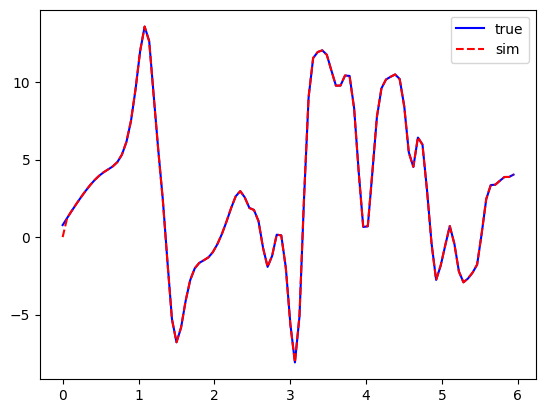

In [ ]:
s = np.s_[:100]

fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Us.T[i, s], label="true", color="blue")
ax.plot(tls[s], Us_sim.T[i, s], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

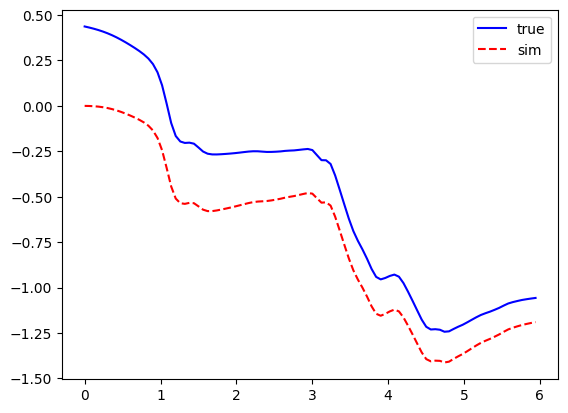

In [ ]:
fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Vs[s, 0, i], label="true", color="blue")
ax.plot(tls[s], Vs_sim[s, 0, i], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

In [ ]:
states = sol.sol(tls)
states_sim = sim.sol(tls)

U_trues, V_trues = zip(*[L96.apart(state, I, J) for state in states.T])
U_trues, V_trues = np.array(U_trues).T, np.array(V_trues).T

U_sims, V_sims = zip(*[L96.apart(state, I, J) for state in states_sim.T])
U_sims, V_sims = np.array(U_sims).T, np.array(V_sims).T

U_error = np.linalg.norm((U_trues - U_sims), axis=0)
rel_U_error = U_error / np.linalg.norm(U_trues, axis=0)

V_error = np.linalg.norm((V_trues - V_sims), axis=(0, 1))
rel_V_error = V_error / np.linalg.norm(V_trues, axis=(0, 1))

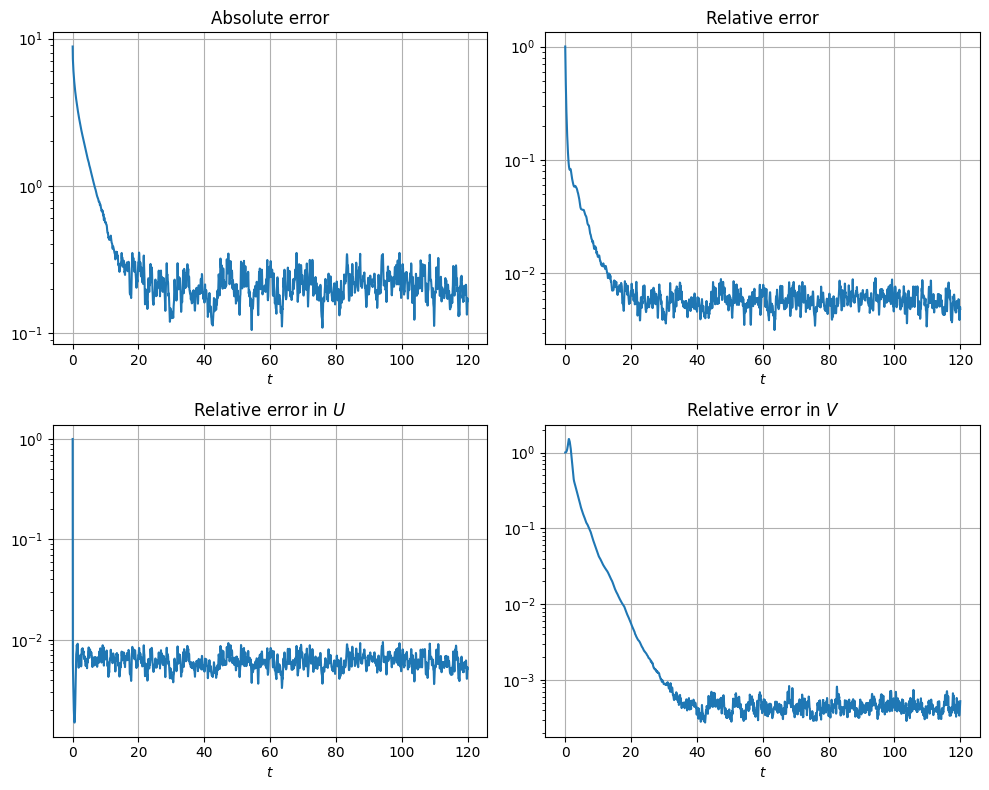

In [ ]:
plot_error(tls, sol.sol, sim.sol, I, J, J_sim)

# Check error at last time step for various $\Delta t$

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = np.array([0.2, 0.5, 1, 2, 5])
F = 8

μ = None
rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)

# Initial true state
init = np.random.default_rng(42).uniform(size=I + I * J)
U0 = init[:I]
V0 = init[I:]

# Initial simulation state
U0_sim = np.zeros_like(U0)
V0_sim = np.zeros_like(V0)

T = 40

dts = [0.025, 0.01, 0.005, 0.0025, 0.001]

def run(rp, dts, μ, results):
    results[μ] = {
        "sols" : [],
        "sims" : [],
    }
    result = results[μ]
    rp.system.μ = μ

    for dt in dts:
        options = {
            "method": RK4,
            "dt": dt,
        }

        sol, sim = rp.evolve(0, T, U0, V0, U0_sim, V0_sim, options)
        result["sols"].append(sol)
        result["sims"].append(sim)

def compute_errors(result):
    tn = 100
    tls = np.linspace(0, T, tn)

    errors, rel_errors = [], []

    for sol, sim in zip(result["sols"], result["sims"]):
        states = sol.sol(tls)
        Us, Vs = zip(*(L96.apart(state, I, J) for state in states.T))
        Us, Vs = np.stack(Us), np.stack(Vs)

        states_sim = sim.sol(tls)
        Us_sim, Vs_sim = zip(*(L96.apart(state, I, J_sim) for state in states_sim.T))
        Us_sim, Vs_sim = np.stack(Us_sim), np.stack(Vs_sim)

        error = np.linalg.norm(states - states_sim, axis=0)
        rel_error = error / np.linalg.norm(states, axis=0)

        errors.append(error[-1])
        rel_errors.append(rel_error[-1])
    
        result["errors"] = errors
        result["rel_errors"] = rel_errors

def plot_errors(result):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    ax = axs[0]
    ax.loglog(dts, result["errors"], marker='o')

    ax.set_xlabel("$\Delta t$")
    ax.set_title("Absolute error")
    ax.grid()

    ax = axs[1]
    ax.loglog(dts, result["rel_errors"], marker='o')

    ax.set_xlabel("$\Delta t$")
    ax.set_title("Relative error")
    ax.grid()

    plt.show()

In [ ]:
results = {}

### Small nudging parameter

In [ ]:
μ = 1
run(rp, dts, μ, results)

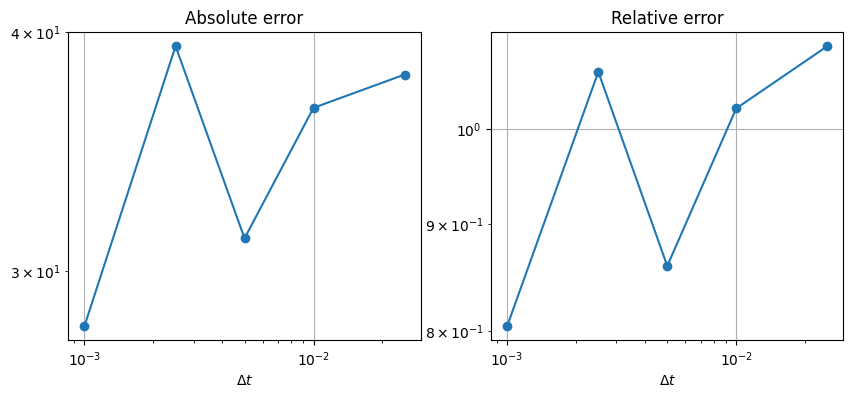

In [ ]:
μ = 1
compute_errors(results[μ])
plot_errors(results[μ])

### Rather small nudging parameter

In [ ]:
μ = 3
run(rp, dts, μ, results)

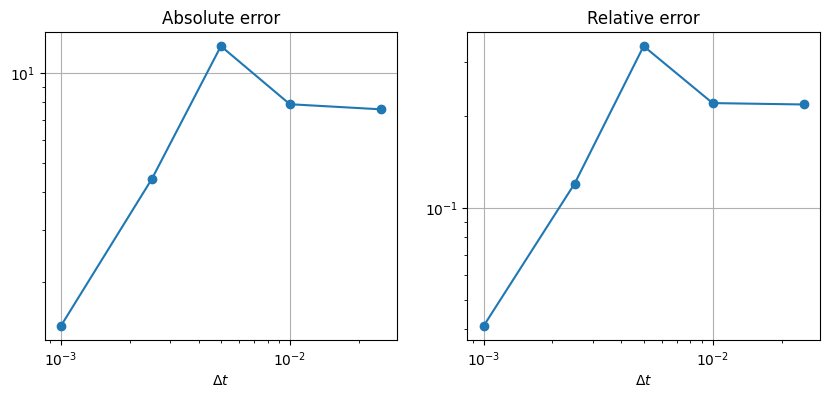

In [ ]:
μ = 3
compute_errors(results[μ])
plot_errors(results[μ])

### Small-ish nudging parameter

In [ ]:
μ = 10
run(rp, dts, μ, results)

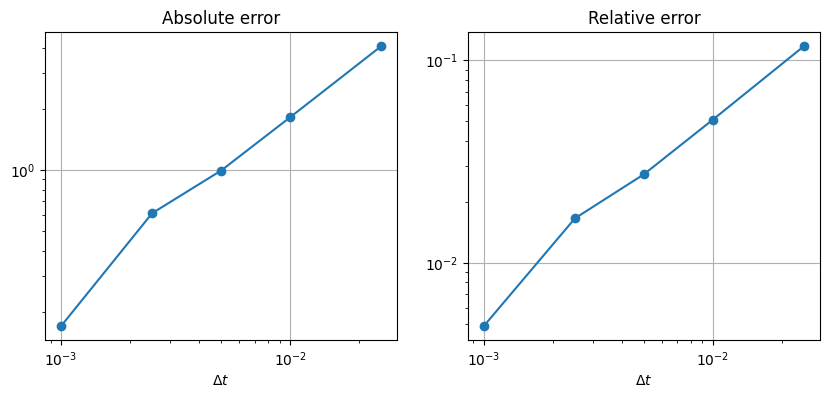

In [ ]:
μ = 10
compute_errors(results[μ])
plot_errors(results[μ])

### Normal nudging parameter

In [ ]:
μ = 50
run(rp, dts, μ, results)

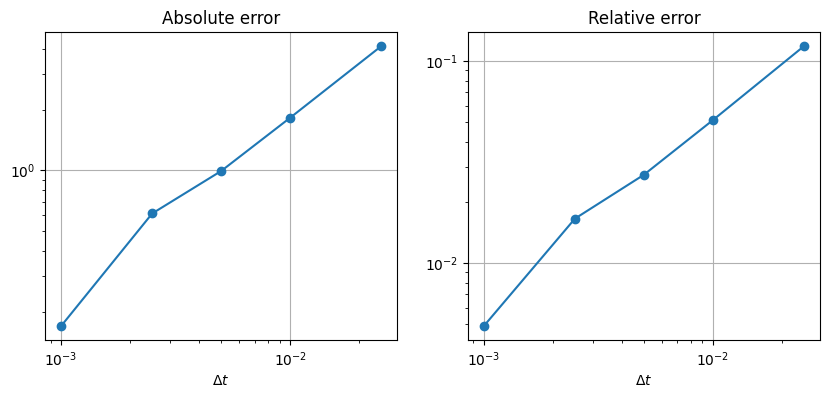

In [ ]:
μ = 50
compute_errors(results[μ])
plot_errors(results[μ])